In [0]:
import tarfile
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/CINIC-10.tar.gz")
tar.extractall()
tar.close()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import torch.nn   
import torch.optim as optim
import torch.nn.functional 
import torchvision.datasets   
import torchvision.transforms     

import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot    
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score

In [0]:
TRAIN_DATA_PATH="/content/train"
transfm=[transforms.CenterCrop(32*0.9)]
data_valid_transform = transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.4598, 0.4520, 0.4116),(0.1902, 0.1869, 0.1896))])
train = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=data_valid_transform)
VLAID_DATA_PATH="/content/valid"
valid = torchvision.datasets.ImageFolder(root=VLAID_DATA_PATH, transform=data_valid_transform)
TEST_DATA_PATH="/content/test"
test = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH)#, transform=data_valid_transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=6)  
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, num_workers=6)    
test_loader = torch.utils.data.DataLoader(test,  batch_size=1, num_workers=6)       

In [0]:
TEST_DATA_PATH="/content/test/"+classnames[count]+"/"
test = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1= nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2= nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.conv3 = nn.Conv2d(32, 16, 2)
        #self.pool3 = nn.MaxPool2d(2, 2)
        #self.bn3= nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc1 = nn.Linear(64*6*6, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.shape)
        x=self.bn1(x)
        #print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x=self.bn2(x)
        #print(x.shape)
        #x = self.pool3(F.relu(self.conv3(x)))
        #x=self.bn3(x)
        x = x.view(-1, 64*6*6)
        nn.Dropout(0.5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.log_softmax(self.fc3(x))
        return x


net = Net()



In [0]:
import torch
net = Net()
net.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/model64"))

<All keys matched successfully>

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# test the model on test dataset
import PIL
from torch.autograd import Variable
net.cuda()
correct = 0
total = 0
accuracy=0.0
predicted_values=[]
real_values=[]
net.eval()
imsize = 32
data_valid_transform = transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.4598, 0.4520, 0.4116),(0.1902, 0.1869, 0.1896))])
    
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = PIL.Image.open(image_name)
    pyplot.imshow(image)
    image = data_valid_transform(image)
    image = image.unsqueeze(0)
    image = torch.autograd.Variable(image.cuda(), requires_grad=True)
    #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

for inputs in test.imgs[0:1]:
    image = image_loader(inputs[0])
    print(inputs[0])
    actual_val = Variable(torch.LongTensor([3]), requires_grad=False)
    actual_val=actual_val.cuda()
    print(image.shape)
    #if(image.size==torch.Size([1, 3, 32, 32])):
    predicted_val = net(image) 
    loss = torch.nn.CrossEntropyLoss()
    loss_cal = loss(predicted_val, actual_val)
    loss_cal.backward(retain_graph=True)
    sign_data_grad = torch.sign(image.grad.data)
    x_adversarial = image - 0.05 * sign_data_grad  # find adv example using formula shown above
    output_adv = net.forward(Variable(x_adversarial))  # perform a forward pass on adv example
    print(output_adv.shape)   
    output_adv=net(x_adversarial)
    predicted_val = output_adv.cpu().data.numpy()
    predicted_val = np.argmax(predicted_val, axis=1)
    print(predicted_val, actual_val)   

AssertionError: ignored

torch.Size([32, 32, 3])


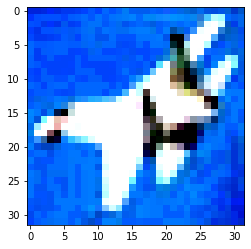

In [0]:
x_adversarial=torch.clamp(x_adversarial, 0, 1)
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.1902, 1/0.1869, 1/0.1896 ]),
                                transforms.Normalize(mean = [ -0.4598, -0.4520, -0.4116 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

mean=(0.4598, 0.4520, 0.4116)
std=(0.1902, 0.1869, 0.1896)
x_adversarial=x_adversarial.squeeze(0)
x_adversarial=x_adversarial.cpu().detach()
x_adv = x_adversarial.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
x_adv = np.transpose( x_adversarial , (1,2,0))   # C X H X W  ==>   H X W X C
x_adv = np.clip(x_adv, 0, 1)

print(x_adv.shape)
pyplot.imshow(x_adv)
#inv_tensor = invTrans(x_adversarial)
#pyplot.imshow(inv_tensor.cpu().detach().numpy())


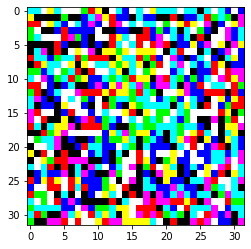

In [0]:
x_grad = sign_data_grad.squeeze(0)
x_grad=x_grad.cpu().detach()
x_grad=x_grad.numpy()
x_grad = np.transpose(x_grad, (1,2,0))
x_grad = np.clip(x_grad, 0, 1)
pyplot.imshow(x_grad)

In [0]:
correct = 0
total = 0
accuracy=0.0
predicted_values=[]
real_values=[]
net.eval()
for inputs, actual_val in test_loader:
    total += 1
    print(inputs[0])
    # perform classification
    predicted_val =net(torch.autograd.Variable(inputs.cuda()))    
    # convert 'predicted_val' GPU tensor to CPU tensor and extract the column with max_score
    predicted_val = predicted_val.cpu().data.numpy()
    predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row     
    predicted_values.extend(predicted_val)   
    real_values.extend(actual_val.numpy())
    current_accuracy=accuracy_score(actual_val.numpy(), predicted_val)
    accuracy += current_accuracy
       
print("Classifier Accuracy on Test Dataset: ", accuracy/total * 100)


TypeError: ignored

In [0]:
"""
Adversary Attack example code
"""
# from torchvision import models as tvm
import torch
from torch.nn import functional as F
from pathlib import Path
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable


class AdversialAttacker(object):

    def __init__(self, method='FGSM'):
        assert method in ['FGSM', 'I-FGSM']
        self.method = method
        self.criterion = torch.nn.CrossEntropyLoss()
        #print("created adversial attacker in method '%s'" % (method))

    def get_pred_label(self, mdl, inp, ret_out_scores=False, ret_out_pred=True):
        # use current model to get predicted label
        train = mdl.training
        mdl.eval()
        with torch.no_grad():
            out = F.softmax(mdl(inp), dim=1)
        out_score, out_pred = out.max(dim=1)
        if ret_out_scores and not ret_out_pred:
            return out
        if ret_out_pred and not ret_out_scores:
            return out_pred
        #mdl.train(train)
        return out_pred, out

    def perturb_untargeted(self, mdl, inp, targ_label=None, eps=0.3):
        # perform attacking perturbation in the untargeted setting
        # note: feel free the change the function arguments for your implementation
        out_pred, out_score=self.get_pred_label(mdl,inp,True,True)
        x_adv = Variable(inp.data, requires_grad=True)
        if self.method == 'FGSM':
            h_adv = mdl(x_adv)
            if targ_label:
                cost = self.criterion(h_adv, targ_label)
            else:
                cost = -self.criterion(h_adv, out_pred)
    
            mdl.zero_grad()
            if x_adv.grad is not None:
                x_adv.grad.data.fill_(0)
            cost.backward()
    
            x_adv.grad.sign_()
            x_adv = x_adv - eps * x_adv.grad
    
            h = mdl(inp)
            h_adv = mdl(x_adv)
    
            return x_adv, h_adv, h

        elif self.method == 'I-FGSM':
            #print("here")
            iteration=10
            alpha=eps/iteration
            # TODO
            # you may add arguments like iter, eps_iter, ...
            out_pred, out_score=self.get_pred_label(mdl,inp,True,True)
            x_adv = Variable(inp.data, requires_grad=True)
            for i in range(iteration):
                #print("here2")
                h_adv = mdl(x_adv)
                #print("here3")
                if targ_label:
                  cost = self.criterion(h_adv, targ_label)
                else:
                  cost = -self.criterion(h_adv, out_pred)
                #print("here3.1")
                mdl.zero_grad()
                if x_adv.grad is not None:
                    x_adv.grad.data.fill_(0)
                cost.backward()
                
                x_adv.grad.sign_()
                x_adv = x_adv - alpha * x_adv.grad
                x_adv = torch.where(x_adv > inp + eps, inp + eps, x_adv)
                x_adv = torch.where(x_adv < inp - eps, inp - eps, x_adv)
                x_adv = Variable(x_adv.data, requires_grad=True)
                #print("here4")
            h = mdl(inp)
            h_adv = mdl(x_adv)
            return x_adv, h_adv, h

    def perturb_targeted(self, mdl, inp, targ_label, eps=0.3):
        # perform attacking perturbation in the targeted setting
        # note: feel free the change the function arguments for your implementation
        #mdl.train()  # switch model to train mode
        out_pred, out_score=self.get_pred_label(mdl,inp,True,True)
        x_adv = Variable(inp.data, requires_grad=True)
        if self.method == 'FGSM':
            h_adv = mdl(x_adv)
            cost = self.criterion(h_adv, targ_label)
    
            mdl.zero_grad()
            if x_adv.grad is not None:
                x_adv.grad.data.fill_(0)
            cost.backward()
    
            x_adv.grad.sign_()
            x_adv = x_adv - eps * x_adv.grad
    
            h = mdl(inp)
            h_adv = mdl(x_adv)
        
            return x_adv, h_adv, h

        elif self.method == 'I-FGSM':
            iteration=10
            alpha=eps/iteration
            # TODO
            # you may add arguments like iter, eps_iter, ...
            out_pred, out_score=self.get_pred_label(mdl,inp,True,True)
            x_adv = Variable(inp.data, requires_grad=True)
            for i in range(iteration):
                #print("here2")
                h_adv = mdl(x_adv)
                #print("here3")
                cost = self.criterion(h_adv, targ_label)
                #print("here3.1")
                mdl.zero_grad()
                if x_adv.grad is not None:
                    x_adv.grad.data.fill_(0)
                cost.backward()
                
                x_adv.grad.sign_()
                x_adv = x_adv - alpha * x_adv.grad
                x_adv = torch.where(x_adv > inp + eps, inp + eps, x_adv)
                x_adv = torch.where(x_adv < inp - eps, inp - eps, x_adv)
                x_adv = Variable(x_adv.data, requires_grad=True)
                #print("here4")
            h = mdl(inp)
            h_adv = mdl(x_adv)
            return x_adv, h_adv, h

class Clamp:
    def __call__(self, inp):
        return torch.clamp(inp, 0., 1.)


def generate_experiment(image_path,method='FGSM'):

    # define your model and load pretrained weights
    # TODO
    # model = ...
    model = Net()
    model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/model64"))

    # cinic class names
    import yaml
    with open('/content/cinic_classnames.yml', 'r') as fp:
        classnames = yaml.safe_load(fp)

    # load image
    # TODO:
    # img_path = Path(....)
    #/content/test/airplane/cifar10-test-9577.png
    input_img = Image.open(image_path)

    # define normalizer and un-normalizer for images
    # cinic
    mean = [0.47889522, 0.47227842, 0.43047404]
    std = [0.24205776, 0.23828046, 0.25874835]

    tf_img = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=mean,
                std=std
            )
        ]
    )
    un_norm = transforms.Compose(
        [
            transforms.Normalize(
                mean=[-m/s for m, s in zip(mean, std)],
                std=[1/s for s in std]
            ),
            Clamp(),
            transforms.ToPILImage()
        ]
    )

    # To be used for iterative method
    # to ensure staying within Linf limits
    clip_min = min([-m/s for m, s in zip(mean, std)])
    clip_max = max([(1-m)/s for m, s in zip(mean, std)])

    input_tensor = tf_img(input_img)
    attacker = AdversialAttacker(method=method)

    return {
        'img': input_img,
        'inp': input_tensor.unsqueeze(0),
        'attacker': attacker,
        'mdl': model,
        'clip_min': clip_min,
        'clip_max': clip_max,
        'un_norm': un_norm,
        'classnames': classnames
    }


In [0]:
count=1
import glob
import yaml
import random
with open('/content/cinic_classnames.yml', 'r') as fp:
  classnames = yaml.safe_load(fp)
TEST_DATA_PATH="/content/test/"+classnames[count]+"/"
test = glob.glob(TEST_DATA_PATH+"*.png")
selectedList=random.sample(test, 50)

In [0]:

import PIL
result={}
target=0
list_image=[]
prevCorrectlyClassified=0
while(target<10):
  prevCorrectlyClassified=0
  #print(test)
  print("Current class:: %s", classnames[target])
  #selectedList=random.choices(range(count*10000, (count+1)*10000), k=200)
  print(selectedList)
  result[classnames[count]]=[]
  for  i in selectedList:
    image=PIL.Image.open(i)
    tensor=transforms.ToTensor()
    #print(tensor(image).shape)
    if tensor(image).shape!=(3,32,32):
      continue
    y_target = Variable(torch.LongTensor(target), requires_grad=False)
    #print(torch.LongTensor([target]))
    x=generate_experiment(i)
    input_img    = x['img']
    input_tensor = x['inp']
    attacker     = x['attacker']
    model        = x['mdl']
    un_norm      = x['un_norm']
    classnames   = x['classnames']
    # run the classifier model
    out_pred, scores = attacker.get_pred_label(model, input_tensor, ret_out_scores=True, ret_out_pred=True)
    x_adv, h_adv, h = attacker.perturb_targeted(model, input_tensor, targ_label=torch.LongTensor([target]), eps=1e-1)
    result[classnames[count]].append({
          'input_tensor':input_tensor,
          'img': input_img,
          'x_adv':x_adv,
          'h_adv':h_adv,
          'h':h,
          'out_pred':out_pred,
          'scores':scores
      })
  output={}
  #print(len(result[classnames[count]]))
  targetAttackSuccessful=0
  for i in range(0,len(result[classnames[count]])):
    h=result[classnames[count]][i]['h']
    h_adv=result[classnames[count]][i]['h_adv']
    img=result[classnames[count]][i]['img']
    out_pred=result[classnames[count]][i]['out_pred']
    scores=result[classnames[count]][i]['scores']
    #out_pred=result[classnames[count]][i]['out_pred']
    x_adv=result[classnames[count]][i]['x_adv']
    input_tensor=result[classnames[count]][i]['input_tensor']
    img_adv = un_norm(x_adv.squeeze(0))
    img_diff = diff_img(img_adv, un_norm(input_tensor.squeeze(0)), scale=1) # you can play with scale to amplify the signals
    img_orig_np = np.array(un_norm(input_tensor.squeeze(0))).astype('float')
    img_adv_np  = np.array(img_adv).astype('float')
    img_diff_np = np.abs( img_adv_np - img_orig_np ).sum(axis=2)
    # run classifier again for the attacked image
    attacked_pred, attacked_score = attacker.get_pred_label(model, x_adv, ret_out_scores=True, ret_out_pred=True)
    
    #print(int(attacked_pred), int(out_pred))
    if int(out_pred)==count:
      prevCorrectlyClassified+=1
      if int(attacked_pred) ==target:
        targetAttackSuccessful+=1
      if prevCorrectlyClassified==10:
       break
      '''if int(attacked_pred) in output:
        output[int(attacked_pred)]=output[int(attacked_pred)]+1
      else:
        output[int(attacked_pred)]=1'''
      
      #list_image.append([img,img_adv,img_diff, img_diff_np])
      list_image.append(img_adv)
      #break
      #print( "original prediction: %d current prediction: %d (%s)\n" % ( int(out_pred),int(attacked_pred), classnames[int(attacked_pred)] ) )
  print(prevCorrectlyClassified,targetAttackSuccessful)
  import operator
#print(prevCorrectlyClassified,targetAttackSuccessful)
  #sorted_output = sorted(output.items(), key=operator.itemgetter(1)) 
  #print(sum(output.values())*100/prevCorrectlyClassified,sum(output.values()))
  #print(classnames[sorted_output[len(sorted_output)-1][0]],"("+str(sorted_output[len(sorted_output)-1][1])+")")
  target+=1
  #showImagesHorizontally(list_image[0])
  


Current class:: %s airplane
['/content/test/automobile/cifar10-test-4245.png', '/content/test/automobile/n03498781_8593.png', '/content/test/automobile/cifar10-test-1061.png', '/content/test/automobile/n03870105_1127.png', '/content/test/automobile/n02831335_18361.png', '/content/test/automobile/n03268790_2547.png', '/content/test/automobile/n03079136_11195.png', '/content/test/automobile/n03141065_14500.png', '/content/test/automobile/n03870105_2615.png', '/content/test/automobile/n03543394_9692.png', '/content/test/automobile/cifar10-test-1591.png', '/content/test/automobile/cifar10-train-34845.png', '/content/test/automobile/n03421669_2890.png', '/content/test/automobile/n03498781_3045.png', '/content/test/automobile/n03543394_3831.png', '/content/test/automobile/n04285965_8810.png', '/content/test/automobile/n02701002_803.png', '/content/test/automobile/n03543394_1300.png', '/content/test/automobile/n03539103_2938.png', '/content/test/automobile/cifar10-test-4206.png', '/content/te

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10 3
Current class:: %s automobile
['/content/test/automobile/cifar10-test-4245.png', '/content/test/automobile/n03498781_8593.png', '/content/test/automobile/cifar10-test-1061.png', '/content/test/automobile/n03870105_1127.png', '/content/test/automobile/n02831335_18361.png', '/content/test/automobile/n03268790_2547.png', '/content/test/automobile/n03079136_11195.png', '/content/test/automobile/n03141065_14500.png', '/content/test/automobile/n03870105_2615.png', '/content/test/automobile/n03543394_9692.png', '/content/test/automobile/cifar10-test-1591.png', '/content/test/automobile/cifar10-train-34845.png', '/content/test/automobile/n03421669_2890.png', '/content/test/automobile/n03498781_3045.png', '/content/test/automobile/n03543394_3831.png', '/content/test/automobile/n04285965_8810.png', '/content/test/automobile/n02701002_803.png', '/content/test/automobile/n03543394_1300.png', '/content/test/automobile/n03539103_2938.png', '/content/test/automobile/cifar10-test-4206.png', '/con

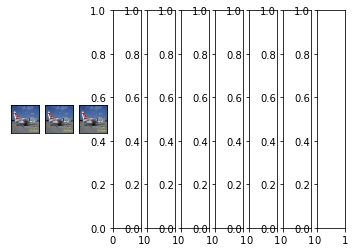

In [0]:
showImagesHorizontally(list_image)

In [0]:
list_image[1]

IndexError: ignored

In [0]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    f,ax = pyplot.subplots(1,10)
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].axes.get_yaxis().set_visible(False)
        ax[i].imshow(image)
    pyplot.show()


In [0]:
def diff_img(img1, img2,scale=1):
    return Image.fromarray(
        scale * np.abs(
            np.array(img1).astype('float') - np.array(img2).astype('float')
        ).astype(np.uint8)
    )


In [0]:
count=2
prevCorrectlyClassified=0
list_image=[]
output={}
print(len(result[classnames[count]]))
for i in range(0,len(result[classnames[count]])):
  currTuple=result[classnames[count]][i]['currTuple']
  h=result[classnames[count]][i]['h']
  h_adv=result[classnames[count]][i]['h_adv']
  img=result[classnames[count]][i]['img']
  out_pred=result[classnames[count]][i]['out_pred']
  scores=result[classnames[count]][i]['scores']
  out_pred=result[classnames[count]][i]['out_pred']
  x_adv=result[classnames[count]][i]['x_adv']
  input_tensor=result[classnames[count]][i]['input_tensor']
  img_adv = un_norm(x_adv.squeeze(0))
  img_diff = diff_img(img_adv, un_norm(input_tensor.squeeze(0)), scale=1) # you can play with scale to amplify the signals
  img_orig_np = np.array(un_norm(input_tensor.squeeze(0))).astype('float')
  img_adv_np  = np.array(img_adv).astype('float')
  img_diff_np = np.abs( img_adv_np - img_orig_np ).sum(axis=2)
  # run classifier again for the attacked image
  attacked_pred, attacked_score = attacker.get_pred_label(model, x_adv, ret_out_scores=True, ret_out_pred=True)
  if int(out_pred)==count:
    prevCorrectlyClassified+=1
    if int(attacked_pred) !=count:
      if int(attacked_pred) in output:
        output[int(attacked_pred)]=output[int(attacked_pred)]+1
      else:
        output[int(attacked_pred)]=1
      list_image.append([img,img_adv,img_diff, img_diff_np])
    #print( "original prediction: %d current prediction: %d (%s)\n" % ( int(out_pred),int(attacked_pred), classnames[int(attacked_pred)] ) )

import operator
print(prevCorrectlyClassified)
sorted_output = sorted(output.items(), key=operator.itemgetter(1)) 
print(sum(output.values())*100/prevCorrectlyClassified,sum(output.values()))
print(classnames[sorted_output[len(sorted_output)-1][0]],"("+str(sorted_output[len(sorted_output)-1][1])+")")
  

NameError: ignored

In [0]:
prevCorrectlyClassified

56

In [0]:
classnames

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
sum(output.values())

39

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# check the classfier scores
print( "current prediction: %d (%s)\n" % ( int(out_pred), classnames[int(out_pred)] ) )


top_scores, top_indices = scores.topk(5)
print( "current top-5 scores:" )
for ss, ii in zip( top_scores.numpy().ravel(), top_indices.numpy().ravel() ):
    print( ' - %d (%s): %.4f' % ( int(ii), classnames[int(ii)], ss ) )

NameError: ignored

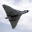

In [0]:
# check the image before attacking
input_img

In [0]:
# now let's attack

# untargeted setting
#x_adv, h_adv, h = attacker.perturb_untargeted(model, input_tensor, eps=1e-2)

# # targeted setting
target_label = Variable(7, requires_grad=False)
#target_label = 7
x_adv, h_adv, h = attacker.perturb_targeted(model, input_tensor, targ_label=[target_label], eps=0.3)


TypeError: ignored

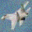

In [0]:
# check the image after attacking
img_adv = un_norm(x_adv.squeeze(0))
img_adv

In [0]:
# visualize the perturbation "directly"
def diff_img(img1, img2,scale=1):
    return Image.fromarray(
        scale * np.abs(
            np.array(img1).astype('float') - np.array(img2).astype('float')
        ).astype(np.uint8)
    )

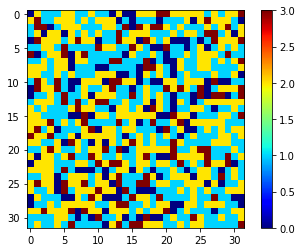

In [0]:
# visualize the perturbation, by heatmap

# note: the image pixel values are in range 0-255
img_orig_np = np.array(un_norm(input_tensor.squeeze(0))).astype('float')
img_adv_np  = np.array(img_adv).astype('float')
img_diff_np = np.abs( img_adv_np - img_orig_np ).sum(axis=2)

import matplotlib.pyplot as plt
plt.imshow(img_diff_np, cmap='jet', vmin=0, vmax=np.array(img_diff_np).max());
plt.colorbar()
plt.show()


In [0]:
# run classifier again for the attacked image
attacked_pred, attacked_score = attacker.get_pred_label(model, x_adv, ret_out_scores=True, ret_out_pred=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
# check scores
print( "current prediction: %d (%s)\n" % ( int(attacked_pred), classnames[int(attacked_pred)] ) )

top_attacked_scores, top_attacked_indices = attacked_score.topk(5)
print( "current top-5 scores:" )
for ss, ii in zip( top_attacked_scores.numpy().ravel(), top_attacked_indices.numpy().ravel() ):
    print( ' - %d (%s): %.4f' % ( int(ii), classnames[int(ii)], ss ) )

print("\nDid we fooled the classifier?")
if int(attacked_pred) != int(out_pred):
    print(' - Yes!')
else:
    print(' - Nah.')    

current prediction: 4 (deer)

current top-5 scores:
 - 4 (deer): 0.9107
 - 3 (cat): 0.0521
 - 5 (dog): 0.0348
 - 2 (bird): 0.0016
 - 6 (frog): 0.0007

Did we fooled the classifier?
 - Yes!
